In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train = np.loadtxt('train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('test.csv', delimiter=',', skiprows=1)

In [3]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]

# приводим размерность к удобному для обаботки виду
# добавляем размерность канала
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28, 1))
test_img = np.resize(test, (test.shape[0], 28, 28, 1))

In [4]:
train_img.shape

(42000, 28, 28, 1)

In [34]:
test_img

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

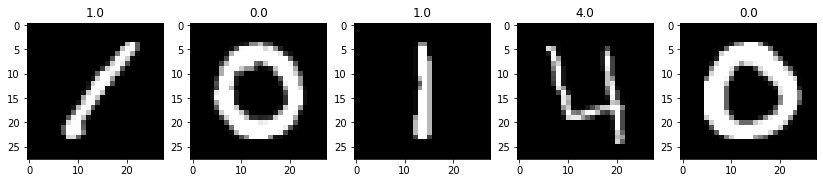

In [5]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5, :], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img[:,:,0].squeeze(), cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

In [6]:
train_img_for_hist = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img_for_hist = np.resize(test, (test.shape[0], 28, 28))

In [7]:
train_sobel_x = np.zeros_like(train_img_for_hist)
train_sobel_y = np.zeros_like(train_img_for_hist)
for i in range(len(train_img_for_hist)):
    train_sobel_x[i] = cv2.Sobel(train_img_for_hist[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img_for_hist[i], cv2.CV_64F, dx=0, dy=1, ksize=3)
test_sobel_x = np.zeros_like(test_img_for_hist)
test_sobel_y = np.zeros_like(test_img_for_hist)
for i in range(len(test_img_for_hist)):
    test_sobel_x[i] = cv2.Sobel(test_img_for_hist[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img_for_hist[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [8]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

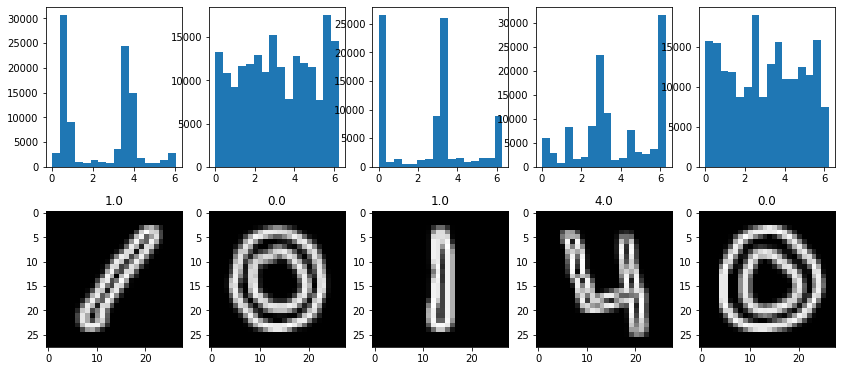

In [9]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

In [10]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [11]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

In [12]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

In [13]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2,
    random_state=42)

In [ ]:
y_train

array([6., 5., 3., ..., 2., 6., 0.])

In [ ]:
x_train

In [14]:
import keras

In [15]:
np.random.seed(42)
model = keras.models.Sequential()
model.add(keras.layers.Dense(1600, input_dim=x_train.shape[1], activation='relu'))
model.add(keras.layers.Dense(1000, activation='relu'))
model.add(keras.layers.Dense(90, activation='sigmoid'))
model.add(keras.layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()
from keras.utils import np_utils
y_train_labels = np_utils.to_categorical(y_train)
y_val_labels = np_utils.to_categorical(y_val)
model.fit(x_train, y_train_labels, batch_size=300, epochs=45, shuffle=True, validation_data=(x_val, y_val_labels))
#pred_val = model.predict_classes(x_val)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1600)              27200     
                                                                 
 dense_1 (Dense)             (None, 1000)              1601000   
                                                                 
 dense_2 (Dense)             (None, 90)                90090     
                                                                 
 dense_3 (Dense)             (None, 10)                910       
                                                                 
Total params: 1,719,200
Trainable params: 1,719,200
Non-trainable params: 0
_________________________________________________________________
Epoch 1/45
112/112 [==============================] - 11s 89ms/step - loss: 1.5413 - accuracy: 0.4364 - val_loss: 1.2373 - val_accuracy: 0.5512
Epoch 2/45
112/112 [==============

In [16]:
predict_x=model.predict(x_val) 
classes_x=np.argmax(predict_x,axis=1)
#pred_val = model.predict_classes(x_val, verbose=0)
from sklearn.metrics import accuracy_score
rate = accuracy_score(y_val, classes_x)
print('Accuracy: %s' % rate)
#rates.append(rate)

263/263 [==============================] - 2s 6ms/step
Accuracy: 0.6689285714285714


In [ ]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test3, 1):
        dst.write('%s,%s\n' % (i, p))

NameError: ignored

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val, classes_x))

              precision    recall  f1-score   support

         0.0       0.45      0.48      0.47       816
         1.0       0.96      0.96      0.96       909
         2.0       0.53      0.51      0.52       846
         3.0       0.63      0.78      0.69       937
         4.0       0.78      0.66      0.72       839
         5.0       0.66      0.64      0.65       702
         6.0       0.54      0.45      0.49       785
         7.0       0.83      0.85      0.84       893
         8.0       0.55      0.55      0.55       835
         9.0       0.69      0.71      0.70       838

    accuracy                           0.67      8400
   macro avg       0.66      0.66      0.66      8400
weighted avg       0.67      0.67      0.67      8400



In [32]:
x_val

array([[0.41281347, 0.368608  , 0.18903207, ..., 0.22811746, 0.0608472 ,
        0.26683354],
       [0.65759467, 0.08075626, 0.03301447, ..., 0.01180928, 0.04207296,
        0.11769157],
       [0.3257592 , 0.50370109, 0.21290177, ..., 0.10697524, 0.09831463,
        0.06179984],
       ...,
       [0.06224049, 0.20412941, 0.25190361, ..., 0.29521826, 0.09386408,
        0.07608923],
       [0.21475273, 0.2003948 , 0.3464693 , ..., 0.08707368, 0.11888592,
        0.11854467],
       [0.28903564, 0.36368445, 0.10787793, ..., 0.10475328, 0.1526668 ,
        0.40338432]])

In [31]:
y_pred = model.predict(x_val)
y_pred_labels = np.argmax(y_pred, axis=1)

263/263 [==============================] - 21s 78ms/step


In [38]:
n=2
x=np.expand_dims(test_img[n],axis=0)
res=model.predict(x)

InvalidArgumentError: ignored

In [36]:
result = model.predict(np.array(test_img))
result = np.argmax(result, axis=1)

InvalidArgumentError: ignored

In [ ]:
y_pred_test = model.predict(test_img)
y_pred_test_labels = np.argmax(y_pred_test, axis=1)

In [ ]:
test_pred=model.predict_generator(test_img, steps=28, verbose=1)

In [ ]:
pred_test = np.zeros(len(test_img), np.uint8)

In [ ]:
pred_test

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)